# Semantic Segmentation on Indian Driving Dataset

In [2]:
!wget --header="Host: doc-0c-10-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Cookie: AUTH_6ctmas63rahb5j94hol136jarcascn5b_nonce=cula27hbv15h0" --header="Connection: keep-alive" "https://doc-0c-10-docs.googleusercontent.com/docs/securesc/nmh6ngado89nceda429lmavom0r346f4/1kfhogpvpnv9nbeg39nhugq6f7en53ls/1602848700000/00607338181599466056/00607338181599466056/1nfCifKEWd43gtRY_zJdm39aWaY5eJ4ic?e=download&authuser=0&nonce=cula27hbv15h0&user=00607338181599466056&hash=jevusd9lmkuscflgfjudq7bpo7g7bb6h" -c -O 'data.zip'

--2020-10-16 11:45:37--  https://doc-0c-10-docs.googleusercontent.com/docs/securesc/nmh6ngado89nceda429lmavom0r346f4/1kfhogpvpnv9nbeg39nhugq6f7en53ls/1602848700000/00607338181599466056/00607338181599466056/1nfCifKEWd43gtRY_zJdm39aWaY5eJ4ic?e=download&authuser=0&nonce=cula27hbv15h0&user=00607338181599466056&hash=jevusd9lmkuscflgfjudq7bpo7g7bb6h
Resolving doc-0c-10-docs.googleusercontent.com (doc-0c-10-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0c-10-docs.googleusercontent.com (doc-0c-10-docs.googleusercontent.com)|64.233.189.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip                [               <=>  ]   2.18G  41.1MB/s    in 27s     

2020-10-16 11:46:04 (83.6 MB/s) - ‘data.zip’ saved [2339740971]



In [ ]:
!unzip data.zip

In [ ]:
!pip3 install keras==2.3.1
!pip3 install tensorflow==2.2.0
!pip3 install -U segmentation-models

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import math 
import json
from collections import Counter
import seaborn as sns
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

<pre>
1. Download the data and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [6]:
def return_file_names_df(basepath):
    column_names=['images', 'json']
    data = pd.DataFrame(columns = column_names)
    image_file=[]
    json_file=[]
    for root,directories,files in os.walk(basepath):
        for filename in files:
            filepath_file=os.path.join(root,filename)
            file_name=filename.split('_')[0]
            if (filename.endswith("jpg")):
                image_file.append((file_name,filepath_file))
            else:
                json_file.append((file_name,filepath_file))

    for img_filename in image_file:
      for json_filename in json_file:
        if (img_filename[0]==json_filename[0]):
          if (((data['images'] == img_filename[1]) | (data['json'] == json_filename[1])).any()):
            pass
          else:
            data=data.append({'images':img_filename[1],'json': json_filename[1]}, ignore_index=True)
            continue
                
    return data

In [7]:
root_dir=r"data"
data_df = return_file_names_df(root_dir)
data_df.head()

,images,json
0,data/images/263/frame67349_leftImg8bit.jpg,data/mask/263/frame67349_gtFine_polygons.json
1,data/images/263/frame68492_leftImg8bit.jpg,data/mask/263/frame68492_gtFine_polygons.json
2,data/images/263/frame33203_leftImg8bit.jpg,data/mask/263/frame33203_gtFine_polygons.json
3,data/images/263/frame33421_leftImg8bit.jpg,data/mask/263/frame33421_gtFine_polygons.json
4,data/images/263/frame27171_leftImg8bit.jpg,data/mask/263/frame27171_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [8]:
data_df.shape

(4008, 2)

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    labels=[]
    for ind in data_df.index: 
        with open(data_df['json'][ind]) as f:
            data1 = json.load(f)
            for i in data1['objects']:
                labels.append(i['label'])
    unique_labels = set(labels)

    plt.figure(figsize=(18,7))
    plt.xticks(rotation=70)
    sns.barplot(list(Counter(labels).keys()), list(Counter(labels).values()))
    
    return unique_labels

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


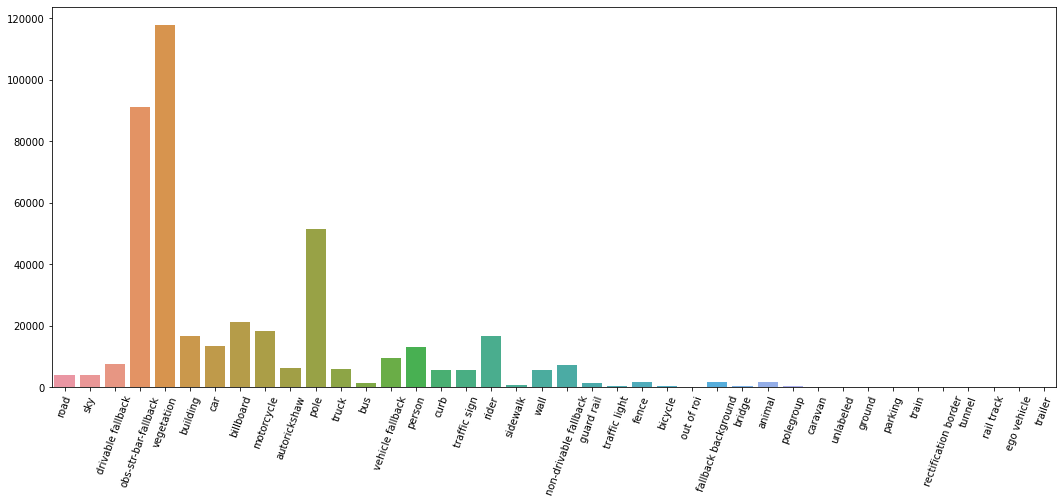

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [9]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before passing it to the models,divide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [10]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    with open(file) as f:
            data1 = json.load(f)

    h=data1['imgHeight']
    w=data1['imgWidth']
    label=[] 
    vertexlist=[]
    
    
    for i in data1['objects']:
        if len(i['polygon'])==0 or len(i['polygon'])==1:
            pass
        
        else:
            label.append(i['label'])
            list1=[]
            for j in i['polygon']:
                list1.append(tuple(j))
            vertexlist.append(list1)
        
    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

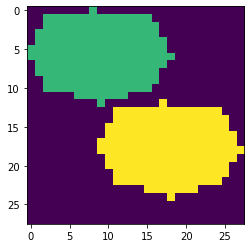

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [12]:
 def compute_masks(data_df): 
    path_list=[]
    for ind in data_df.index: 
        # after you have computed the vertexlist plot that polygone in image like this
        w, h, label, vertexlist = get_poly(data_df['json'][ind])
        # img = Image.new("RGB", (w, h))
        img = Image.new("RGB", (w,h))
        img1 = ImageDraw.Draw(img)
         # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
        for i in range(0,len(vertexlist)):
            img1.polygon(vertexlist[i], fill = label_clr[label[i]])
         # after drawing all the polygons that we collected from json file, 
        # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
        img=np.array(img)
        # note that the filling of the values happens at the channel 1, so we are considering only the first channel here
        plt.imshow(img[:,:,0])
        im = Image.fromarray(img[:,:,0])
        # after saving the image into disk, store the path in a list
        # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
        t=("data/output/")
        filename=(data_df['json'][ind].split('/')[2])
        filename1=(((data_df['json'][ind].split('/')[2])+('/')+(data_df['json'][ind].split('/')[3])).split('.')[0])
        if not os.path.exists(t+filename):
            os.makedirs(t+filename)
        im.save(f"{t+filename1}.png")
        path_list.append(f"{t+filename1}.png")
    data_df['mask']=pd.DataFrame(path_list)
    return data_df

In [14]:
data_df = compute_masks(data_df)
data_df.head()

,images,json,mask
0,data/images/263/frame67349_leftImg8bit.jpg,data/mask/263/frame67349_gtFine_polygons.json,data/output/263/frame67349_gtFine_polygons.png
1,data/images/263/frame68492_leftImg8bit.jpg,data/mask/263/frame68492_gtFine_polygons.json,data/output/263/frame68492_gtFine_polygons.png
2,data/images/263/frame33203_leftImg8bit.jpg,data/mask/263/frame33203_gtFine_polygons.json,data/output/263/frame33203_gtFine_polygons.png
3,data/images/263/frame33421_leftImg8bit.jpg,data/mask/263/frame33421_gtFine_polygons.json,data/output/263/frame33421_gtFine_polygons.png
4,data/images/263/frame27171_leftImg8bit.jpg,data/mask/263/frame27171_gtFine_polygons.json,data/output/263/frame27171_gtFine_polygons.png


In [15]:
data_df.shape

(4008, 3)

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


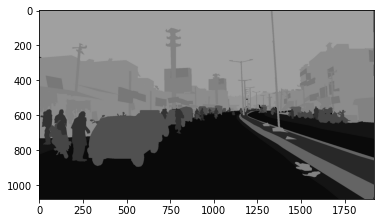

In [16]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* installed it like this "pip install -U segmentation-models==0.2.1", even in google colab and installed the    same with "!pip install -U segmentation-models==0.2.1" 


* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

<pre>

<img src='https://i.imgur.com/VDE2nd2.jpg' width="500">
fig 1
* Above Fig shows the equation of Dice coefficient, in which pi and gi 
represent pairs of corresponding pixel values of      prediction and ground 
truth, respectively. In boundary detection scenario, the values of pi and gi 
are either 0 or 1, representing whether the pixel is boundary (value of 1) or
 not (value of 0). Therefore, the denominator is the sum of total boundary
  pixels of both prediction and ground truth, and the numerator is the sum of 
  correctly predicted boundary pixels because the sum increments only when pi 
  and gi match (both of value 1).

<img src='https://i.imgur.com/YI39904.jpg'  width="500">
fig 2

* Fig.2 is another view of Fig.1 from the perspective of set theory, in which
 the Dice coefficient (DSC) is a measure of overlap between two sets. For 
 example, if two sets A and B overlap perfectly, DSC gets its maximum value to
  1. Otherwise, DSC starts to decrease, getting to its minimum value to 0 if 
  the two sets don ‘t overlap at all. Therefore, the range of DSC is between 0
   and 1, the larger the better. Thus, we can use 1-DSC as Dice loss to 
   maximize the overlap between two sets. 

* DSC starts to decrease, getting to its minimum value to 0 if the two sets don
 't overlap at all. Therefore, the range of DSC is between 0 and 1, the larger 
 the better. Thus, we can use 1-DSC as Dice loss to maximize the overlap 
 between two sets.


* In segmentation tasks, the class label pixels and predicted class label 
pixels can be viewed as two sets. By leveraging Dice loss, the two sets are 
trained to overlap one by one. As shown in Fig.2, the denominator considers the
 total number of boundary pixels at global scale, while the numerator considers
  the overlap between the two sets at local scale, Thus Dice loss is 
  considering the loss information.

</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [3]:
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import tensorflow as tf
import keras

Using TensorFlow backend.


In [4]:
data_df=pd.read_csv("preprocessed_data.csv")
X_train, X_test = train_test_split(data_df, test_size=0.1, random_state=42, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(3607, 3)
(401, 3)


In [19]:
X_train.head(2)

,images,json,mask
1322,data/images/206/frame1539_leftImg8bit.jpg,data/mask/206/frame1539_gtFine_polygons.json,data/output/206/frame1539_gtFine_polygons.png
2965,data/images/377/frame26162_leftImg8bit.jpg,data/mask/377/frame26162_gtFine_polygons.json,data/output/377/frame26162_gtFine_polygons.png


In [5]:
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self,data,augmentation=None):
        

        self.ids = data.index
        # the paths of images 
        self.images_fps   = [data_df['images'].iloc[image_id] for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [data_df['mask'].iloc[image_id] for image_id in self.ids]
        
        # giving labels for each class  
        self.class_values = list(range(0,210,10))
        self.augmentation=augmentation
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        new_image = normalize_image(new_image)
        new_image = cv2.resize(new_image, (512,512), interpolation = cv2.INTER_NEAREST)

        new_mask = cv2.resize(mask, (512,512), interpolation = cv2.INTER_NEAREST)
        
        # new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
        # new_mask = cv2.cvtColor(new_mask, cv2.COLOR_BGR2RGB)

        image_masks = [(new_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.augmentation==True:
            aug3 = iaa.Flipud(1)
            aug4 = iaa.Emboss(alpha=(1), strength=1)
            aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
            aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))
            a = np.random.uniform()
            if a<0.4:
                new_image = aug3.augment_image(new_image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                new_image = aug4.augment_image(new_image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                new_image = aug5.augment_image(new_image)
                image_mask = image_mask
            else:
                new_image = aug6.augment_image(new_image)
                image_mask = aug6.augment_image(image_mask)
                
        return new_image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [6]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
# tf.keras.backend.clear_session()
import segmentation_models as sm
# SM_FRAMEWORK=keras
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [7]:
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', encoder_freeze=True, input_shape=(512,512,3))

In [8]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [10]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import IOUScore
from segmentation_models import Unet
optim = keras.optimizers.Adam()

focal_loss = sm.losses.DiceLoss()+sm.losses.CategoricalCELoss()

iou_score=IOUScore(threshold=0.52 ,per_image=True)
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim,loss=focal_loss, metrics=[iou_score])

In [11]:
# Dataset for train images

train_dataset = Dataset(X_train,augmentation=True)
test_dataset  = Dataset(X_test)

batch_size=5
train_dataloader = Dataloder(train_dataset, batch_size, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size, shuffle=True)

print((train_dataloader[0][0].shape))
assert train_dataloader[0][0].shape == (batch_size, 512,512, 3)
assert train_dataloader[0][1].shape == (batch_size, 512,512, 21)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)
]

(5, 512, 512, 3)


In [13]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,\
                              validation_data=test_dataloader,callbacks=callbacks )

Epoch 1/3
721/721 [==============================] - 870s 1s/step - loss: 0.8158 - iou_score: 0.5027 - val_loss: 1.0692 - val_iou_score: 0.4371
Epoch 2/3
721/721 [==============================] - 878s 1s/step - loss: 0.8862 - iou_score: 0.4807 - val_loss: 0.8140 - val_iou_score: 0.4876
Epoch 3/3
721/721 [==============================] - 875s 1s/step - loss: 0.7964 - iou_score: 0.4821 - val_loss: 0.7478 - val_iou_score: 0.5027


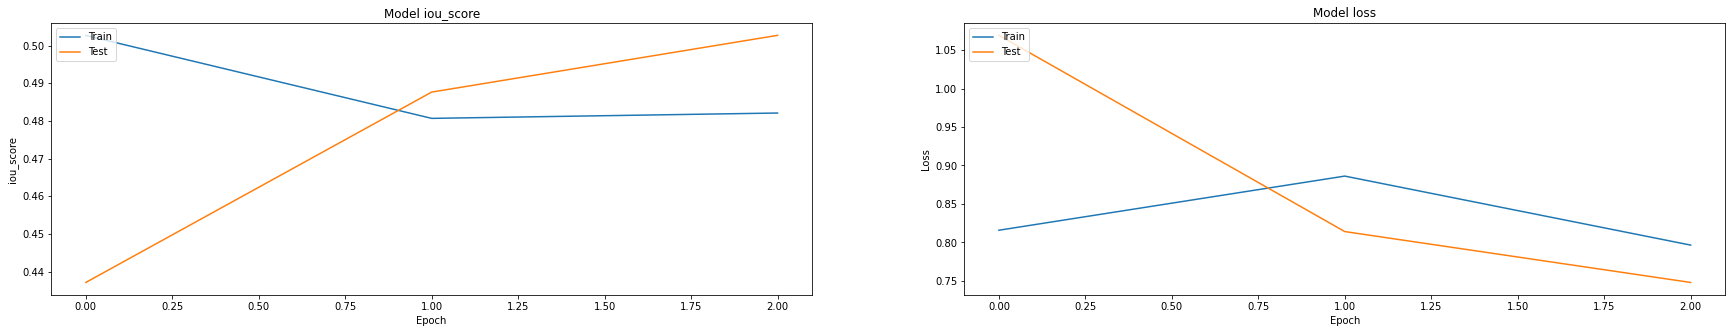

In [14]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

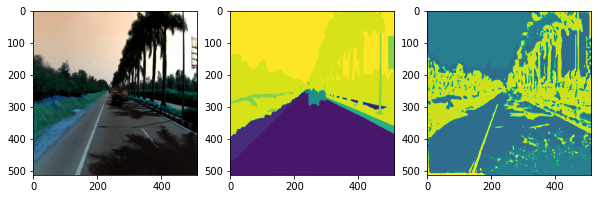

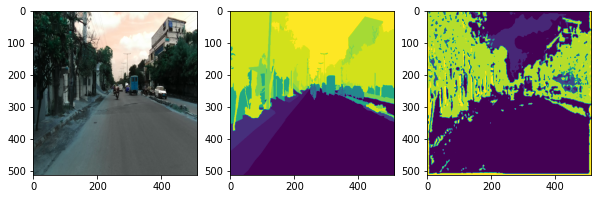

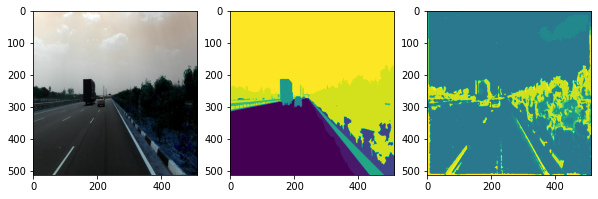

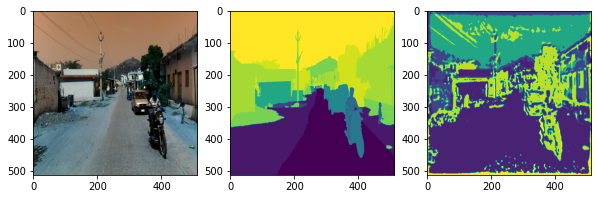

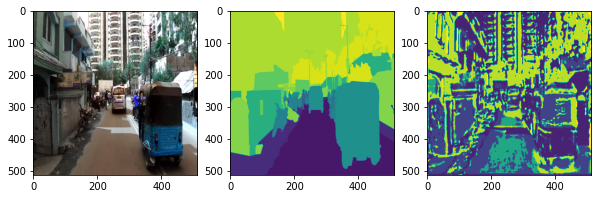

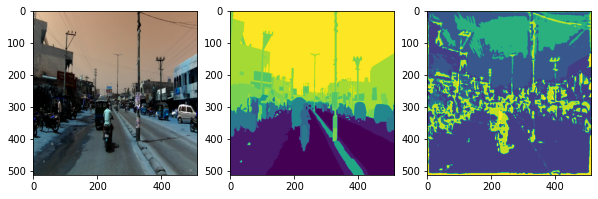

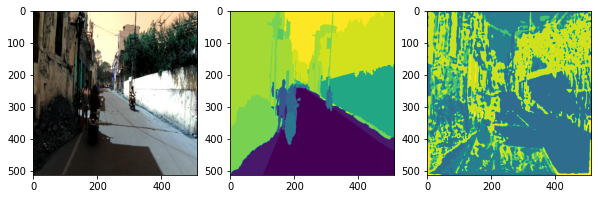

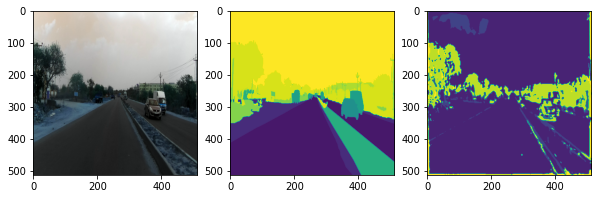

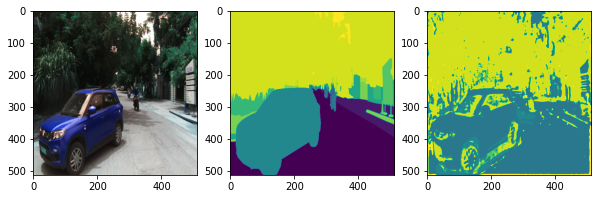

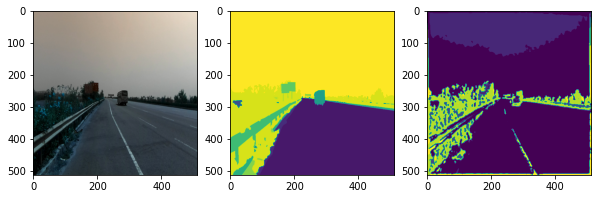

In [15]:
import random
test_imageid_list=[]
for image_id in X_test.index:
    test_imageid_list.append(image_id)

for i in range(0,10):
    j=random.choice(test_imageid_list)
    #original image
    image_index=data_df['images'].iloc[j]
    image = cv2.imread(image_index, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512))
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    mask_index=data_df['mask'].iloc[j]
    image_mask = cv2.imread(mask_index, cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))


    

    prediction = tf.argmax(predicted, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    # plt.imshow(predicted)
    plt.imshow(pred_mask[:,:,0])
    plt.show()  

# Task 3: Training CANet

In [6]:
tf.keras.backend.clear_session()
import segmentation_models as sm
# SM_FRAMEWORK=tf.keras
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import optimizers

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [7]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.conv2d_1=Conv2D(self.F1, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_2=Conv2D(self.F2, (3, 3),strides=self.stride, padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_3=Conv2D(self.F3, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_p_llel=Conv2D(self.F3, (3, 3),strides=self.stride, padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.batch_norm=BatchNormalization(axis=-1)
        self.batch_norm1=BatchNormalization(axis=-1)
        self.batch_norm2=BatchNormalization(axis=-1)
        self.batch_norm3=BatchNormalization(axis=-1)
        self.activation=Activation('relu')
        
    def call(self, X):
        # write the architecutre that was mentioned above
        output_conv1=self.conv2d_1(X)
        output_BN_1=self.batch_norm(output_conv1)
        output_act_1=self.activation(output_BN_1)
        output_conv2=self.conv2d_2(output_act_1)
        output_BN_2=self.batch_norm1(output_conv2)
        output_act_2=self.activation(output_BN_2)
        output_conv3=self.conv2d_3(output_act_2)
        output_BN_3=self.batch_norm2(output_conv3)
        
        output_conv_p_llel=self.conv2d_p_llel(X)
        output_BN_p_llel=self.batch_norm3(output_conv_p_llel)
        output_act_p_llel=self.activation(output_BN_p_llel)
        
        ele_sum=tf.keras.layers.Add()([output_BN_3,output_act_p_llel])
        
        X=self.activation(ele_sum)
        
        return X

In [8]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv2d_1=Conv2D(self.F1, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_2=Conv2D(self.F2, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_3=Conv2D(self.F3, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.batch_norm=BatchNormalization(axis=-1)
        self.batch_norm1=BatchNormalization(axis=-1)
        self.batch_norm2=BatchNormalization(axis=-1)
        self.activation=Activation('relu')
    def call(self, X):
        # write the architecutre that was mentioned above
        output_conv1=self.conv2d_1(X)
        output_BN_1=self.batch_norm(output_conv1)
        output_act_1=self.activation(output_BN_1)
        output_conv2=self.conv2d_2(output_act_1)
        output_BN_2=self.batch_norm1(output_conv2)
        output_act_2=self.activation(output_BN_2)
        output_conv3=self.conv2d_3(output_act_2)
        output_BN_3=self.batch_norm2(output_conv3)
        
        
        ele_sum=tf.keras.layers.Add()([output_BN_3,X])
        
        X=self.activation(ele_sum)
        
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [9]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.global_avg=tf.keras.layers.GlobalAveragePooling2D()
        self.batch_norm=BatchNormalization(axis=-1)
        self.relu = tf.keras.layers.ReLU()
        self.conv2d=Conv2D(64, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
    def call(self, X):
        # implement the global flow operatiom
        output_gobal_avg=self.global_avg(X)
        output_reshape=tf.reshape(output_gobal_avg,[-1,1,1,64])
        output_batch_norm=self.batch_norm(output_reshape)
        output_relu=self.relu(output_batch_norm)
        output_convd=self.conv2d(output_relu)
        X=tf.keras.layers.UpSampling2D(size=(64,64),interpolation='bilinear')(output_convd)
        return X

In [10]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.concat=tf.keras.layers.Concatenate(axis=-1)
        self.avg_pool=tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')
        self.conv2d_1=Conv2D(64, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_2=Conv2D(64, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_3=Conv2D(64, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_4=Conv2D(64, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.activ_sigmoid = tf.keras.activations.sigmoid
        self.relu=tf.keras.layers.ReLU()
        self.upsamp=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        output_concat=self.concat([INP,FLOW])
        output_avg_pool=self.avg_pool(output_concat)
        output_conv_1=self.conv2d_1(output_avg_pool)
        output_cond2=self.conv2d_2(output_conv_1)
        output_cond3=self.conv2d_3(output_cond2)
        output_relu=self.relu(output_cond3)
        output_cond4=self.conv2d_4(output_relu)
        output_sigmoid=self.activ_sigmoid(output_cond4)
        mul_output=tf.keras.layers.multiply((output_cond2,output_sigmoid))
        add_output=tf.keras.layers.Add()([output_cond2,mul_output])
        X=self.upsamp(add_output)
        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [11]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv2d_1=Conv2D(64, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.gobal_max=tf.keras.layers.GlobalMaxPool2D()
        self.conv2d_2=Conv2D(64, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.batch_norm=BatchNormalization(axis=-1)
        self.active_sigmoid=tf.keras.activations.sigmoid
        self.mul=tf.keras.layers.Multiply()
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        output_conv_1=self.conv2d_1(X)
        output_gobal_max=self.gobal_max(output_conv_1)
        tensor_reshape=tf.reshape(output_gobal_max,[-1,1,1,64])
        output_conv_2=self.conv2d_2(tensor_reshape)
        output_batch_norm=self.batch_norm(output_conv_2)
        output_sigmoid=self.active_sigmoid(output_batch_norm)
        FSM_Conv_T=self.mul([output_conv_1,output_sigmoid])
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [12]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv2d_1=Conv2D(8, (7, 1),strides=(1,1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_2=Conv2D(8, (1, 7),strides=(1,1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_3=Conv2D(8, (1, 7),strides=(1,1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_4=Conv2D(8, (7, 1),strides=(1,1), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.conv2d_5=Conv2D(8, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.add_output=tf.keras.layers.Add()
    def call(self, X):
        # please implement the above mentioned architecture
        output_conv_1=self.conv2d_1(X)
        output_conv_2=self.conv2d_2(output_conv_1)
        output_conv_3=self.conv2d_3(X)
        output_conv_4=self.conv2d_4(output_conv_3)
        output_add_1=self.add_output([output_conv_2,output_conv_4])
        output_conv_5=self.conv2d_4(output_add_1)
        X=self.add_output([output_add_1,output_conv_5])
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [13]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self):
        super().__init__()
        
        self.C1 = convolutional_block(filters=[4,4,8], stride=2)
        self.C2 = convolutional_block(filters=[8,8,16], stride=2)
        self.C3 = convolutional_block(filters=[16,16,32])
        self.C4 = convolutional_block(filters=[32,32,64])
        self.Identity_1=identity_block(filters=[4,4,8])
        self.Identity_2=identity_block(filters=[8,8,16])
        self.Identity_3=identity_block(filters=[16,16,32])
        self.Identity_4=identity_block(filters=[32,32,64])
        self.global_1=global_flow()
        self.context_flow=context_flow()
        self.fsm1=fsm()
  
    def call(self,X):
        '''
              This function takes a input of the encoder.
              Pass the  input to the C1->L1->C2->L2->C3->L3->C4->L4 layer, Pass the ouput to gobal
              returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        output_C1=self.C1(X)
        output_L1=self.Identity_1(output_C1)
        output_C2=self.C2(output_L1)
        output_L2=self.Identity_2(output_C2)
        output_C3=self.C3(output_L2)
        output_L3=self.Identity_3(output_C3)
        output_C4=self.C4(output_L3)
        output_L4=self.Identity_4(output_C4)
        output_global=self.global_1(output_L4)
        output_context_flow1=self.context_flow([output_L4,output_global])
        output_context_flow2=self.context_flow([output_L4,output_context_flow1])
        output_context_flow3=self.context_flow([output_L4,output_context_flow2])
        output_sum1 = tf.keras.layers.Add()([output_global,output_context_flow1,output_context_flow2,output_context_flow3])
        output_fsm=self.fsm1(output_sum1)
        return output_fsm,output_L1

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.upsamp=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
        self.agcn1=agcn()
        self.concat1=tf.keras.layers.Concatenate(axis=-1)
        self.conv2d_1=Conv2D(21, (3,3), strides=(1, 1), padding='same',activation='relu',kernel_initializer=glorot_uniform(seed=0))
        self.upsamp1=tf.keras.layers.UpSampling2D(size=(4,4),interpolation='bilinear')
        self.activation_softmax = Activation('softmax')
    def call(self,X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        output_upsamp_1=self.upsamp(INP)
        print()
        output_agcn=self.agcn1(FLOW)
        output_concat=self.concat1([output_upsamp_1,output_agcn])
        output_conv2d=self.conv2d_1(output_concat)
        output_upsamp_2=self.upsamp1(output_conv2d)
        output=self.activation_softmax(output_upsamp_2)
        return output

In [15]:
class encoder_decoder(tf.keras.Model):
    def __init__(self):
    #Intialize objects from encoder decoder
        super().__init__() # https://stackoverflow.com/a/27134600/4084039

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.conv2d=Conv2D(64, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.batch_norm=BatchNormalization(axis=-1)
        self.relu1=Activation('relu')
        self.max_pool= MaxPooling2D((2, 2), strides=(2, 2))
    def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
        X = self.conv2d(data)
        X = self.batch_norm(X)
        X = self.relu1(X)
        input = self.max_pool(X)
        encoder_output1,encoder_output2 = self.encoder(input)
        decoder_output = self.decoder([encoder_output1,encoder_output2])
        
        return decoder_output

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [20]:
# write the complete architecutre
from segmentation_models.metrics import IOUScore
model_2 = encoder_decoder()
# optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.DiceLoss()+sm.losses.CategoricalCELoss()

iou_score=IOUScore(threshold=0.5 ,per_image=True)
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model_2.compile(optimizer='adam',loss=focal_loss, metrics=[iou_score])

In [21]:
# Dataset for train images

train_dataset = Dataset(X_train,augmentation=True)
test_dataset  = Dataset(X_test)

batch_size=10
train_dataloader = Dataloder(train_dataset, batch_size, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (batch_size, 512,512, 3)
assert train_dataloader[0][1].shape == (batch_size, 512,512, 21)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model_2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

(10, 512, 512, 3)


In [22]:
history = model_2.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5,\
                              validation_data=test_dataloader,callbacks=callbacks )


Epoch 1/5


360/360 [==============================] - 653s 2s/step - loss: 0.9367 - iou_score: 0.4374 - val_loss: 0.9278 - val_iou_score: 0.4444 - lr: 0.0010
Epoch 2/5
360/360 [==============================] - 647s 2s/step - loss: 0.8356 - iou_score: 0.4440 - val_loss: 0.8637 - val_iou_score: 0.4658 - lr: 0.0010
Epoch 3/5
360/360 [==============================] - 638s 2s/step - loss: 0.7967 - iou_score: 0.4573 - val_loss: 0.8408 - val_iou_score: 0.4781 - lr: 0.0010
Epoch 4/5
360/360 [==============================] - 633s 2s/step - loss: 0.7447 - iou_score: 0.4830 - val_loss: 0.8061 - val_iou_score: 0.4798 - lr: 1.0000e-04
Epoch 5/5
360/360 [==============================] - 621s 2s/step - loss: 0.7302 - iou_score: 0.4914 - val_loss: 0.7945 - val_iou_score: 0.4909 - lr: 1.0000e-04


In [23]:
model_2.summary()

Model: "encoder_decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  230840    
_________________________________________________________________
decoder_4 (Decoder)          multiple                  15453     
_________________________________________________________________
conv2d_209 (Conv2D)          multiple                  1792      
_________________________________________________________________
batch_normalization_154 (Bat multiple                  256       
_________________________________________________________________
activation_49 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
Total params: 248,341
Trainable params: 246,757
Non-trainable params: 1,584
_______________________________________

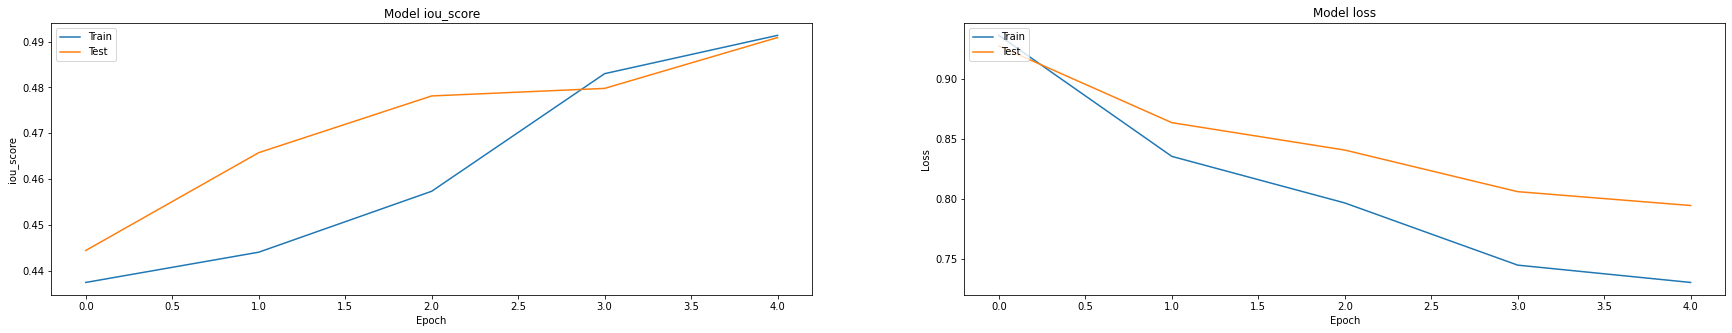

In [24]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

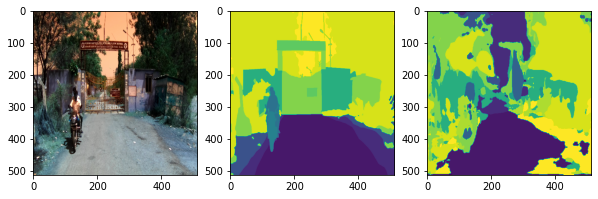

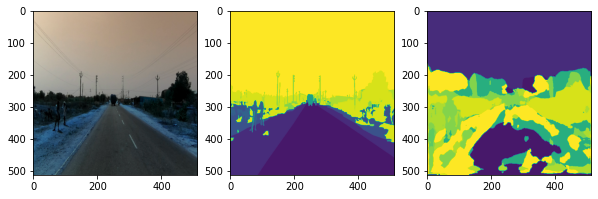

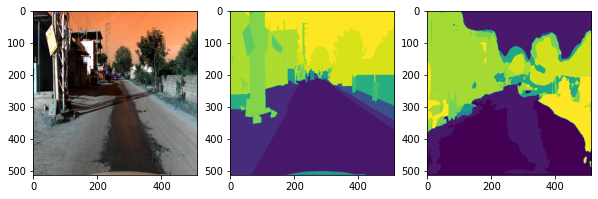

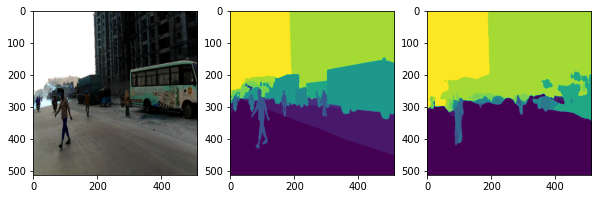

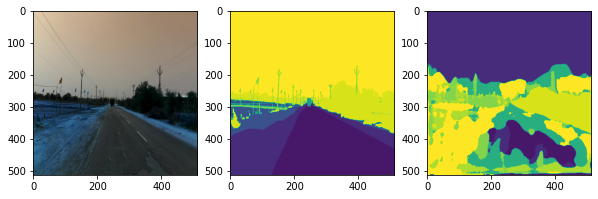

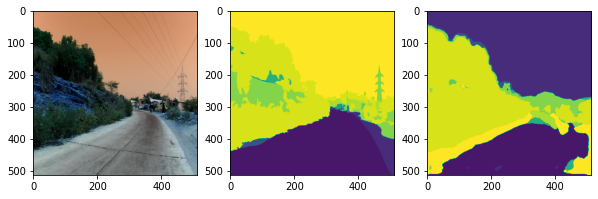

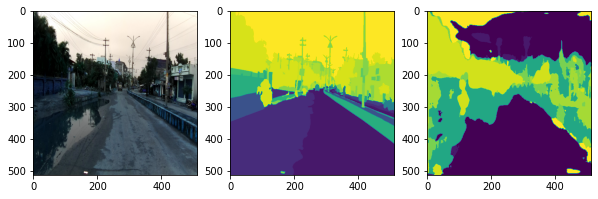

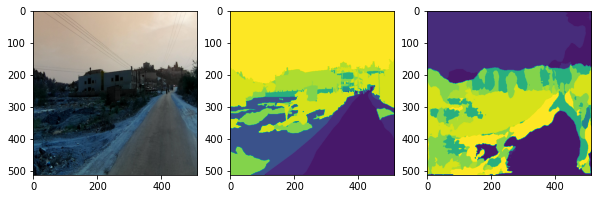

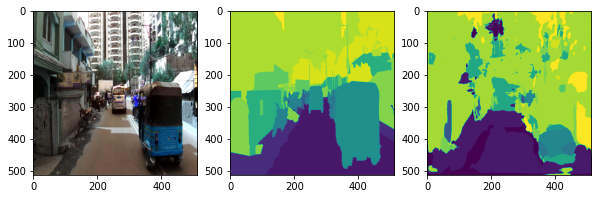

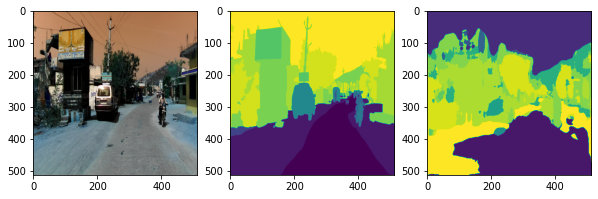

In [25]:
import random
test_imageid_list=[]
for image_id in X_test.index:
    test_imageid_list.append(image_id)

for i in range(0,10):
    j=random.choice(test_imageid_list)
    #original image
    image_index=data_df['images'].iloc[j]
    image = cv2.imread(image_index, cv2.IMREAD_UNCHANGED)
    image = normalize_image(image)
    image = cv2.resize(image, (512,512))
    
    #predicted segmentation map
    predicted  = model_2.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    mask_index=data_df['mask'].iloc[j]
    image_mask = cv2.imread(mask_index, cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))


    

    prediction = tf.argmax(predicted, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    # plt.imshow(predicted)
    plt.imshow(pred_mask[:,:,0])
    plt.show()  

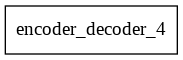

In [26]:
tf.keras.utils.plot_model(
    model_2, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [16]:
from prettytable import PrettyTable

# Representing results in a table
pt = PrettyTable()

pt.field_names = ["Model", "Val_Loss", "Val_IoU_score"]
pt.add_row(["UNet",0.7478,0.5027])
pt.add_row(["CNet",0.7945, 0.4904])
print(pt)

+-------+----------+---------------+
| Model | Val_Loss | Val_IoU_score |
+-------+----------+---------------+
|  UNet |  0.7478  |     0.5027    |
|  CNet |  0.7945  |     0.4904    |
+-------+----------+---------------+


* Two different models (UNet and CNet(modelsubclassing) were implemented.
* Both these models have performed well in the computer vision for Semantic Segmentation.
* For this dataset, UNet gives a Val IoU score of 0.5027 while CNet gives a Val IoU of 0.4904 .